<a href="https://colab.research.google.com/github/RaphaelRGM/Gera-o-de-M-scaras-com-SAM2/blob/main/Segmentacao_geracao_Mascaras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 89.4 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [ ]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from IPython.display import display
from PIL import Image
import json

In [ ]:
DEVICE = 'cpu'
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

'Colab Notebooks'   Segmentacao_geracao_Mascaras.ipynb


✅ Imagem carregada com sucesso!
✅ Imagem salva em: /content/drive/MyDrive/Coqueiros_Saída/imagem_selecionada.png


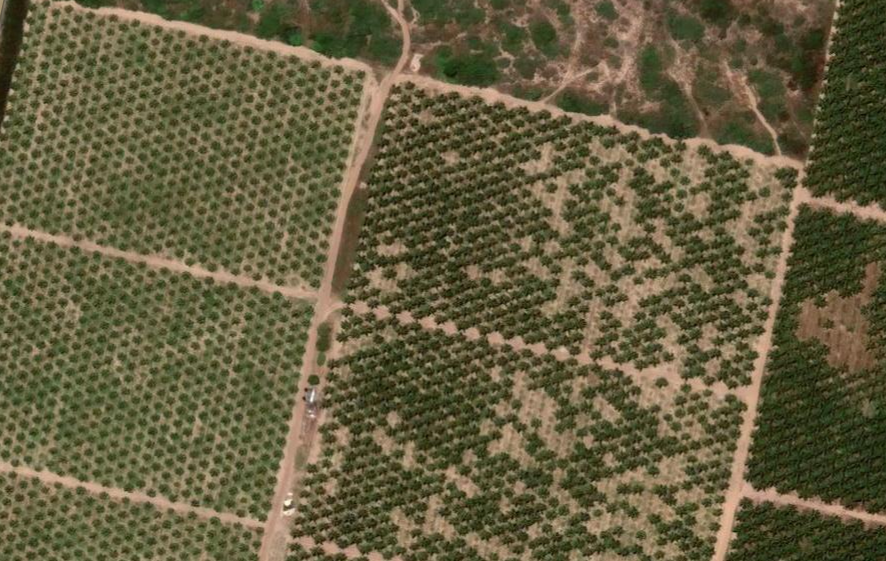

In [ ]:
# Definir a imagem que será usada
IMAGE_PATH = "/content/drive/MyDrive/PlantaçãoCoqueiros.png"

# Diretório onde vamos salvar a imagem de saída
SAVE_DIR = "/content/drive/MyDrive/Coqueiros_Saída"
os.makedirs(SAVE_DIR, exist_ok=True)

# Caminho para salvar a imagem sem combinação
output_image_path = os.path.join(SAVE_DIR, "imagem_selecionada.png")

# Carregar a única imagem
image = cv2.imread(IMAGE_PATH)

# Verificar se a imagem foi carregada corretamente
if image is None:
    print(f"❌ Erro: Não foi possível carregar a imagem {IMAGE_PATH}")
else:
    print("✅ Imagem carregada com sucesso!")

    # Salvar a imagem no diretório de saída
    cv2.imwrite(output_image_path, image)
    print(f"✅ Imagem salva em: {output_image_path}")

    # Exibir a imagem salva
    display(Image.open(output_image_path))

In [ ]:
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 264, 'y': 94, 'width': 16, 'height': 16, 'label': ''},
 {'x': 257, 'y': 136, 'width': 13, 'height': 16, 'label': ''},
 {'x': 232, 'y': 302, 'width': 14, 'height': 14, 'label': ''},
 {'x': 549, 'y': 273, 'width': 14, 'height': 20, 'label': ''},
 {'x': 605, 'y': 218, 'width': 21, 'height': 18, 'label': ''},
 {'x': 494, 'y': 192, 'width': 16, 'height': 19, 'label': ''},
 {'x': 433, 'y': 310, 'width': 18, 'height': 22, 'label': ''},
 {'x': 174, 'y': 452, 'width': 15, 'height': 13, 'label': ''},
 {'x': 389, 'y': 447, 'width': 19, 'height': 17, 'label': ''}]

In [ ]:
# Caminho do arquivo JSON para salvar as bounding boxes
bbox_save_path = os.path.join(SAVE_DIR, "bounding_boxes_combinada.json")

# Criar um dicionário para armazenar as bounding boxes associadas à imagem combinada
bbox_data = {IMAGE_PATH: widget.bboxes}

# Salvar bounding boxes no JSON
with open(bbox_save_path, "w") as f:
    json.dump(bbox_data, f, indent=4)

print(f"✅ **Bounding boxes salvas com sucesso em:** {bbox_save_path}")

# Reabrir JSON para confirmar os dados salvos
with open(bbox_save_path, "r") as f:
    data = json.load(f)
    print("📂 Bounding Boxes Salvas:")
    print(json.dumps(data, indent=4))

✅ **Bounding boxes salvas com sucesso em:** /content/drive/MyDrive/Coqueiros_Saída/bounding_boxes_combinada.json
📂 Bounding Boxes Salvas:
{
    "/content/drive/MyDrive/Plantac\u0327a\u0303oCoqueiros.png": [
        {
            "x": 264,
            "y": 94,
            "width": 16,
            "height": 16,
            "label": ""
        },
        {
            "x": 257,
            "y": 136,
            "width": 13,
            "height": 16,
            "label": ""
        },
        {
            "x": 232,
            "y": 302,
            "width": 14,
            "height": 14,
            "label": ""
        },
        {
            "x": 549,
            "y": 273,
            "width": 14,
            "height": 20,
            "label": ""
        },
        {
            "x": 605,
            "y": 218,
            "width": 21,
            "height": 18,
            "label": ""
        },
        {
            "x": 494,
            "y": 192,
            "width": 16,
            "he

In [ ]:
with open(bbox_save_path, "r") as f:
    bbox_data = json.load(f)

# Pegar bounding boxes do JSON
boxes = bbox_data.get(IMAGE_PATH, [])  # Se não houver bounding boxes, retorna lista vazia

# **Verificar se há bounding boxes**
if not boxes:
    print("❌ Nenhuma bounding box encontrada no JSON. Verifique o arquivo.")
else:
    print(f"✅ {len(boxes)} bounding boxes carregadas!")

# **Converter bounding boxes para formato esperado pelo SAM2**
boxes = np.array([
    [
        box["x"],
        box["y"],
        box["x"] + box["width"],
        box["y"] + box["height"]
    ] for box in boxes
])

✅ 9 bounding boxes carregadas!


In [ ]:
# Carregar a imagem combinada
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Definir a imagem para inferência no SAM2
predictor.set_image(image_rgb)

# Rodar segmentação com SAM2 usando as bounding boxes
masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# Se houver mais de uma máscara, remover dimensões extras
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)

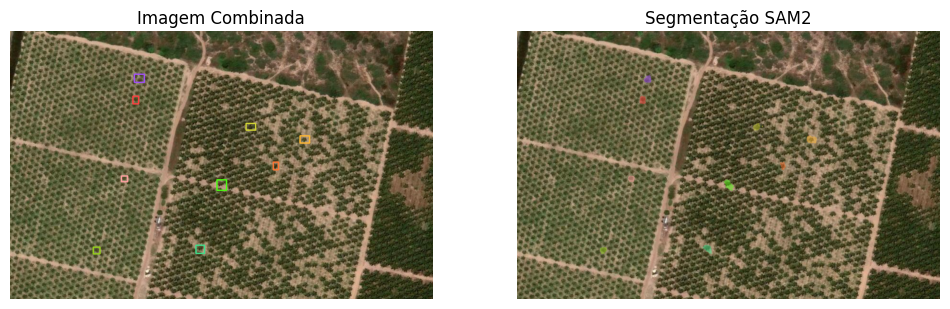

In [ ]:
# Criar anotadores
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Criar detecções para visualizar
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

# Aplicar segmentação à imagem
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Mostrar imagem original vs. segmentada
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=["Imagem Combinada", "Segmentação SAM2"]
)

✅ 9 máscaras carregadas para combinar!
✅ Máscara combinada salva em: /content/drive/MyDrive/Coqueiros_Saída/combined_mask.png


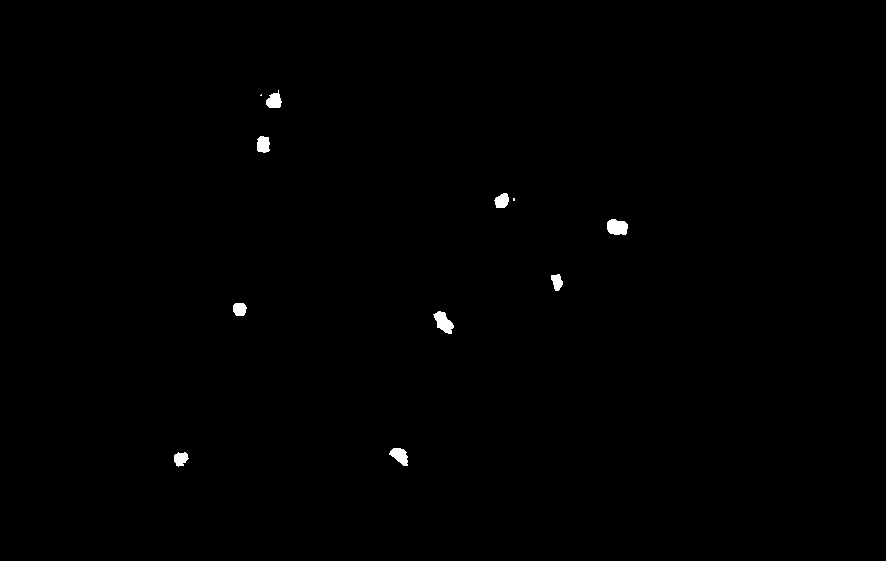

In [ ]:
# Diretório onde as máscaras individuais estão salvas
MASKS_DIR = "/content/drive/MyDrive/Coqueiros_Saída/masks"

# Caminho para salvar a máscara final combinada
combined_mask_path = "/content/drive/MyDrive/Coqueiros_Saída/combined_mask.png"

# Verificar se há máscaras salvas
if len(detections.mask) == 0:
    print("❌ Nenhuma máscara encontrada para combinar.")
else:
    print(f"✅ {len(detections.mask)} máscaras carregadas para combinar!")

    # Criar uma matriz vazia do tamanho da primeira máscara
    combined_mask = np.zeros_like(detections.mask[0], dtype=np.uint8)

    # Percorrer todas as máscaras e combiná-las
    for mask in detections.mask:
        combined_mask = np.maximum(combined_mask, (mask * 255).astype(np.uint8))  # Combinação usando valor máximo

    # Salvar a máscara combinada
    cv2.imwrite(combined_mask_path, combined_mask)
    print(f"✅ Máscara combinada salva em: {combined_mask_path}")

    # Exibir a máscara combinada
    from IPython.display import display
    from PIL import Image
    display(Image.open(combined_mask_path))